# 라이브러리 불러오기

In [1]:
#필요한 library 들을 load 합니다.
import os 
from glob import glob
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

import numpy as np
import pandas as pd
from tqdm import tqdm
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import seaborn as sns

# Image handling
from torchvision import datasets, transforms
from PIL import Image

# Pytorch
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, RandomSampler, SequentialSampler, ConcatDataset
from torchvision import models

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

# Augmenting library 
import albumentations as A
import torchvision.transforms as T

# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

import warnings
warnings.filterwarnings("ignore")

# 데이터 load

이후 추가할 데이터 정규화를 위해, Train 데이터를 모두 훑어주면서 평균과 분산을 찾아줍니다.

RGB 채널별로 평균과 표준편차를 구해줍니다.

데이터 정규화를 시켜주는 이유는 간단히 다음과 같습니다.

1. 평균을 0, 분산을 1로 만들어줌으로써 학습 속도를 증가

2. Train/Val 과 Test 데이터의 분포가 다름(Dataset Shift Problem)으로써 나오는 악영향을 줄임

등등, https://hyen4110.tistory.com/20

In [2]:
temp_transform = T.Compose([
    T.ToTensor(), #이미지 데이터를 tensor 데이터 포멧으로 바꾸어줍니다.
    # T.Resize([224, 224]), #이미지의 크기가 다를 수 있으니 크기를 통일해 줍니다.
    # T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) #픽셀 단위 데이터를 정규화 시켜줍니다.
])

# R_mean = data[0][:, 0].mean().numpy()
# G_mean = data[0][:, 1].mean().numpy()
# B_mean = data[0][:, 2].mean().numpy()

# R_std = data[0][:, 0].std().numpy()
# G_std = data[0][:, 1].std().numpy()
# B_std = data[0][:, 2].std().numpy()

R_mean = 0.4912
G_mean = 0.4820
B_mean = 0.4465

R_std = 0.2457
G_std = 0.2429
B_std = 0.2610

Pytorch는 String 형태의 레이블을 입력받지 못하므로, 숫자형태로 매핑해줍니다.

In [3]:
submission = pd.read_csv('./data/sample_submission.csv')
train_imgs = glob('./data/train/*/*')
train_labels = [path.split('\\')[1] for path in train_imgs]
test_imgs = glob('./data/test/*')

# Pytorch는 String 형태의 label을 입력받지 못합니다.
label_map = {
    'airplane' : 0, 
    'automobile': 1, 
    'bird': 2,
    'cat': 3, 
    'deer': 4, 
    'dog': 5, 
    'frog': 6,
    'horse': 7, 
    'ship': 8, 
    'truck': 9,
}

# Dataset 정의

In [4]:
class train_dataset(Dataset):
    def __init__(self, imgs, labels, transform = None):
        super(train_dataset, self).__init__()
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        assert len(self.imgs) == len(self.labels)
        return len(self.imgs)
    
    def __getitem__(self, idx):
        X = np.array(Image.open(self.imgs[idx]))
        y = label_map[self.labels[idx]]
        
        if self.transform:
            img = self.transform(image = X)['image']
        else:
            img = X
    
        y = torch.tensor(y, dtype = torch.long)
        return {
            'img' : img,
            'label' : y
        }
    
class test_dataset(Dataset):
    def __init__(self, imgs, transform = None):
        super(test_dataset, self).__init__()
        self.imgs = imgs
        self.transform = transform
        # self.n_tta = n_tta
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        X = np.array(Image.open(self.imgs[idx]))
        if self.transform:
            img = self.transform(image = X)['image']
            return img
        else:
            return X

# Config

하이퍼파라미터들을 설정해 줍니다.

batch_size 란 하드웨어에 한번에 load 할 데이터의 크기입니다. 

num_workers 란 데이터 로드 멀티 프로세싱을 위한 파라미터입니다. Windows에서는 따로 설정하면 에러납니다.

Train 데이터 batch_size는 적당한 값, val/test 데이터는 하드웨어가 감당하는 최대한 큰 값으로 하면 좋습니다.

In [5]:
re_size = 32

train_batch_size = 16
valid_batch_size = 128
test_batch_size = 128

epochs = 100
learning_rate = 1e-5 * train_batch_size

save_name = f'js_resnet18_r{re_size}_b{train_batch_size}_lr{learning_rate}_e{epochs}'
save_path = f'models/{save_name}.pt'

# 데이터 증강 (Augmentation)

데이터 형태마다 고유의 증강 기법이 존재합니다. 

증강을 통해 Train 데이터에 변형을 주어 다양성(Variability)를 높이고, Bias를 낮춰 앞서 말한 Dataset shift 문제에 대처할 수 있습니다.

즉, 과적합(Overfitting)에 조금 더 강건한 모델을 만들 수 있습니다.

이미지에는 다음과 같은 증강 기법들이 존재합니다. 컴퓨터 비전 관련한 수업을 들으신 분들은 익숙하실 것입니다.
1. 픽셀 단위 증강 : 가우시안 블러링, 가우시안 노이즈 추가, 픽셀 정규화, Grayscaling 등
2. 공간 수준 증강(Spatial-level Augmentation): Resize, Crop, Rotate, Flip, Shift 등 

- 이외에도 Cutout, Mixup, CutMix, Augmix 등 다양한 증강 기법들이 개발되고 있습니다.

**Validation 및 Test 데이터에는 Augmentation을 적용하면 안 됩니다. (정규화 제외)**
- Test-time Augmentation(TTA)라는 기법이 있긴 하지만, 여기서는 적용하지 않겠습니다.

In [6]:
from albumentations.pytorch import ToTensorV2
import cv2

train_transform = A.Compose([
    A.Resize(re_size, re_size, interpolation=cv2.INTER_AREA),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.GaussNoise(p=0.3),
    A.OneOf([
        A.MotionBlur(blur_limit = 3, p = 1.0),
        A.MedianBlur(blur_limit = 3, p = 1.0),
        A.Blur(blur_limit = 3, p = 1.0),
        ], p = 0.3),
    A.ShiftScaleRotate(rotate_limit = 30),
    A.OneOf([
        A.OpticalDistortion(p = 1.0),
        A.GridDistortion(p = 1.0),
        ], p = 0.3),
    A.OneOf([
        A.CLAHE(clip_limit = 2),
        A.RandomBrightnessContrast(),
        ], p = 0.3),
    A.HueSaturationValue(p = 0.3),
    A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    ToTensorV2(),
])

else_transform = A.Compose([
    A.Resize(re_size, re_size, interpolation=cv2.INTER_AREA),
    A.Normalize(mean=(R_mean, G_mean, B_mean), std=(R_std, G_std, B_std)),
    ToTensorV2(),
])

Train/Val split

In [7]:
train_data = datasets.ImageFolder(root='./data/train/',transform=temp_transform)
train_imgs = glob('./data/train/*/*')
train_labels = [path.split('\\')[1] for path in train_imgs]
test_imgs = glob('./data/test/*')

# Pytorch는 String 형태의 label을 입력받지 못합니다.
label_map = {
    'airplane' : 0, 
    'automobile': 1, 
    'bird': 2,
    'cat': 3, 
    'deer': 4, 
    'dog': 5, 
    'frog': 6,
    'horse': 7, 
    'ship': 8, 
    'truck': 9,
}

train_imgs, val_imgs, train_labels, val_labels = train_test_split(train_imgs, train_labels, test_size = 0.2,
                                                                  stratify = train_labels, random_state = 42)
len(train_imgs), len(val_imgs), len(train_labels), len(val_labels)

(40000, 10000, 40000, 10000)

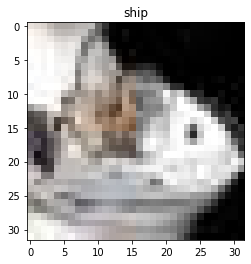

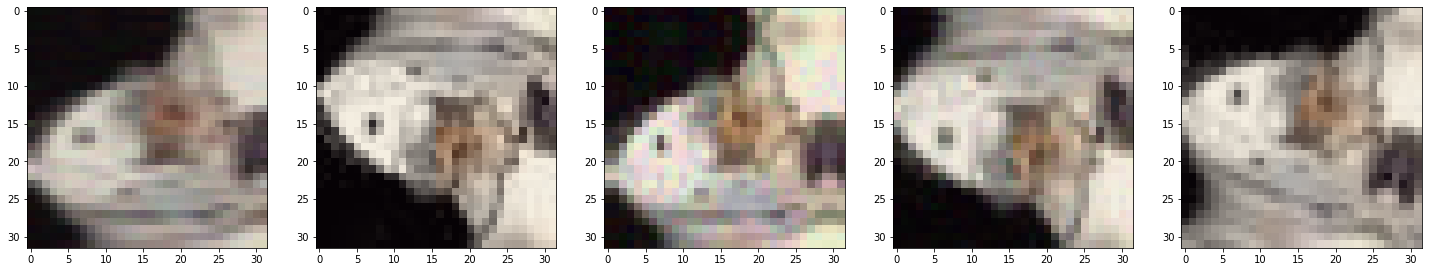

In [8]:
def display_aug(imgs, transform, labels = None, n_aug = 5, cols = 5):
    idx = random.randint(0, len(imgs) - 1)
    
    plt.imshow(np.array(Image.open(imgs[idx])))
    
    if labels:
        label = labels[idx]
        plt.title(label)
    plt.show()
    
    rows = int(np.ceil(n_aug / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize = (cols * 5, rows * 5))

    for i in range(n_aug):
        img = np.array(Image.open(imgs[idx]))
        img = transform(image = img)['image']
        img = np.clip(img.numpy().transpose(1, 2, 0) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
        axes.flat[i].imshow(img)
    plt.show()

display_aug(train_imgs, train_transform, labels = train_labels)

data loader 를 생성해줍니다. 

data loader 란 데이터 셋을 순회하며 모델에 데이터를 넣어주는 객체입니다. 

In [9]:
train_loader = DataLoader(train_dataset(train_imgs, train_labels, transform = train_transform),
                          shuffle = True, batch_size = train_batch_size)
val_loader = DataLoader(train_dataset(val_imgs, val_labels, transform = else_transform),
                        shuffle = False, batch_size = valid_batch_size)

In [10]:
next(iter(train_loader))['img'].shape, next(iter(train_loader))['label']

# (B, C, H, W), (B, num_classes)

(torch.Size([16, 3, 32, 32]),
 tensor([1, 4, 9, 3, 4, 8, 7, 7, 4, 2, 2, 3, 8, 9, 9, 6]))

# Device 설정

device 를 설정해줍니다.

이번 베이스라인에서는 gpu 가 있다고 가정하겠습니다. 

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.is_available()

True

# Model

전이학습을 위한 모델을 load 해줍니다. 

PYTORCH 의 models 메소드를 사용하면 손쉽게 외부의 모델을 불러올 수 있습니다.

이번 베이스라인에서는 efficientnet_b3 모델을 사용해 볼 것입니다. 

사전 학습 모델을 사용하는 것은 부정행위에 해당하니, pretrained 파라미터를 False 로 설정해야 합니다!

pretrained 파라미터를 True 로 설정한다면, ImageNet 이라는 데이터셋을 대상으로 학습된 모델이 load 됩니다.

반면, pretrained 파라미터를 False 로 설정한다면, 모델의 구조만 load 되고 모델의 가중치 들은 load 되지 않습니다. 

In [12]:
model = models.resnet18(pretrained=False)

In [13]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

모델에 데이터를 학습하기 위해서는 모델의 마지막 layer 의 output size 와 분류할 라벨의 수를 입력해주어야 합니다.

즉, 끝단만 바꿔줍니다.

In [14]:
model.fc = nn.Linear(512, 10)

In [15]:
sample_img = next(iter(train_loader))['img']
sample_lab = next(iter(train_loader))['label']
model(sample_img)[0], sample_lab[0]

(tensor([-0.4182,  0.4049,  0.0280,  0.4534,  0.4298, -0.1928, -0.0976, -0.1131,
          0.1403,  0.4279], grad_fn=<SelectBackward0>),
 tensor(8))

In [16]:
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate)

# 학습 

train/validate 함수를 따로 정의해주었습니다.

In [17]:
from sklearn.metrics import f1_score 
import gc

def train(model, loader, epoch, nb_epochs):
    print(f'Epoch {epoch+1}/{nb_epochs}')
    running_loss = 0.0
    # running_f1 = 0.0
    running_corrects = 0
    model.train()
    # scaler = torch.cuda.amp.GradScaler()
    # y_true = []
    # y_pred = []

    for idx, batch in enumerate(tqdm(loader)):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # with torch.cuda.amp.autocast():
        #     output = model(img, csv_feature)
        #     loss = criterion(output, label)

        # scaler.scale(loss).backward() # ADDED - mixed precision + gradient clipping
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        # scaler.step(optimizer)
        # scaler.update()
        
        # forward + backward + optimize
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        # stats
        preds = torch.argmax(output, dim=1)
        correct = torch.eq(preds, label).sum()
        running_loss += loss.item() 
        running_corrects+=correct

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects / len(loader.dataset)
    # epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
    # epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')

    writer.add_scalar('Loss/Train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
    # writer.add_scalar('F1_macro/Train', epoch_f1_macro, epoch)
    # writer.add_scalar('F1_weighted/Train', epoch_f1_weighted, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)

    # print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f},\
    # lr: {optimizer.param_groups[0]["lr"]:.6f}')
    print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, lr: {optimizer.param_groups[0]["lr"]:.6f}')    
    # scheduler.step()
    
def validate(model, loader, epoch, nb_epochs):
    running_loss = 0.0
    # running_f1 = 0.0
    running_corrects = 0
    model.eval()
    # y_true = []
    # y_pred = []

    with torch.no_grad():
        for idx, batch in enumerate(loader):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_loss += loss.item() 
            running_corrects+=correct


        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = running_corrects / len(loader.dataset)
        # epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        # epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        writer.add_scalar('Loss/Valid', epoch_loss, epoch)
        writer.add_scalar('Accuracy/Valid', epoch_acc, epoch)
        # writer.add_scalar('F1_macro/Valid', epoch_f1_macro, epoch)
        # writer.add_scalar('F1_weighted/Valid', epoch_f1_weighted, epoch)
        
        print(f'{running_corrects}/{len(loader.dataset)} correct' )
        # print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')
        print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}')
        
        val_acc_list.append(epoch_acc.cpu().numpy())
        # val_f1_macro_list.append(epoch_f1_macro)
        # val_f1_weighted_list.append(epoch_f1_weighted)
        
        if np.max(val_acc_list) == val_acc_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            print(f'Saving, ACC: {val_acc_list[-1]:.6f}')
            torch.save(model.state_dict(), save_path)
            

gc.collect()

18105

In [18]:
print(save_name)
print(save_path)

js_resnet18_r32_b16_lr0.00016_e100
models/js_resnet18_r32_b16_lr0.00016_e100.pt


In [19]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/' + save_name)
val_acc_list = []
model.to(device)

for epoch in range(epochs):
    train(model, train_loader, epoch, epochs)
    validate(model, val_loader, epoch, epochs)

Epoch 1/100


100%|██████████| 2500/2500 [01:19<00:00, 31.50it/s]


Train loss: 1.837255, Train ACC: 0.331725, lr: 0.000160
4668/10000 correct
Valid loss: 1.462539, Valid ACC: 0.466800
Saving, ACC: 0.466800
Epoch 2/100


100%|██████████| 2500/2500 [01:16<00:00, 32.53it/s]


Train loss: 1.610826, Train ACC: 0.419675, lr: 0.000160
5408/10000 correct
Valid loss: 1.279584, Valid ACC: 0.540800
Saving, ACC: 0.540800
Epoch 3/100


100%|██████████| 2500/2500 [01:14<00:00, 33.60it/s]


Train loss: 1.501003, Train ACC: 0.459725, lr: 0.000160
5727/10000 correct
Valid loss: 1.207112, Valid ACC: 0.572700
Saving, ACC: 0.572700
Epoch 4/100


100%|██████████| 2500/2500 [01:14<00:00, 33.40it/s]


Train loss: 1.423513, Train ACC: 0.493475, lr: 0.000160
6024/10000 correct
Valid loss: 1.124055, Valid ACC: 0.602400
Saving, ACC: 0.602400
Epoch 5/100


100%|██████████| 2500/2500 [01:16<00:00, 32.72it/s]


Train loss: 1.350394, Train ACC: 0.520750, lr: 0.000160
6192/10000 correct
Valid loss: 1.085670, Valid ACC: 0.619200
Saving, ACC: 0.619200
Epoch 6/100


100%|██████████| 2500/2500 [01:16<00:00, 32.77it/s]


Train loss: 1.297675, Train ACC: 0.539325, lr: 0.000160
6431/10000 correct
Valid loss: 1.000630, Valid ACC: 0.643100
Saving, ACC: 0.643100
Epoch 7/100


100%|██████████| 2500/2500 [01:18<00:00, 32.04it/s]


Train loss: 1.260164, Train ACC: 0.554750, lr: 0.000160
6712/10000 correct
Valid loss: 0.948100, Valid ACC: 0.671200
Saving, ACC: 0.671200
Epoch 8/100


100%|██████████| 2500/2500 [01:16<00:00, 32.63it/s]


Train loss: 1.211394, Train ACC: 0.570775, lr: 0.000160
6550/10000 correct
Valid loss: 0.977458, Valid ACC: 0.655000
Epoch 9/100


100%|██████████| 2500/2500 [01:16<00:00, 32.85it/s]


Train loss: 1.178586, Train ACC: 0.585000, lr: 0.000160
6947/10000 correct
Valid loss: 0.887680, Valid ACC: 0.694700
Saving, ACC: 0.694700
Epoch 10/100


100%|██████████| 2500/2500 [01:16<00:00, 32.69it/s]


Train loss: 1.150509, Train ACC: 0.594375, lr: 0.000160
6917/10000 correct
Valid loss: 0.877079, Valid ACC: 0.691700
Epoch 11/100


100%|██████████| 2500/2500 [01:16<00:00, 32.70it/s]


Train loss: 1.124969, Train ACC: 0.606425, lr: 0.000160
7034/10000 correct
Valid loss: 0.847134, Valid ACC: 0.703400
Saving, ACC: 0.703400
Epoch 12/100


100%|██████████| 2500/2500 [01:17<00:00, 32.26it/s]


Train loss: 1.105984, Train ACC: 0.609325, lr: 0.000160
7125/10000 correct
Valid loss: 0.835600, Valid ACC: 0.712500
Saving, ACC: 0.712500
Epoch 13/100


100%|██████████| 2500/2500 [01:18<00:00, 31.76it/s]


Train loss: 1.081877, Train ACC: 0.620675, lr: 0.000160
7096/10000 correct
Valid loss: 0.828729, Valid ACC: 0.709600
Epoch 14/100


100%|██████████| 2500/2500 [01:19<00:00, 31.59it/s]


Train loss: 1.070802, Train ACC: 0.625150, lr: 0.000160
7188/10000 correct
Valid loss: 0.809134, Valid ACC: 0.718800
Saving, ACC: 0.718800
Epoch 15/100


100%|██████████| 2500/2500 [01:18<00:00, 31.71it/s]


Train loss: 1.047762, Train ACC: 0.633325, lr: 0.000160
7101/10000 correct
Valid loss: 0.822948, Valid ACC: 0.710100
Epoch 16/100


100%|██████████| 2500/2500 [01:19<00:00, 31.60it/s]


Train loss: 1.023441, Train ACC: 0.640700, lr: 0.000160
7225/10000 correct
Valid loss: 0.782186, Valid ACC: 0.722500
Saving, ACC: 0.722500
Epoch 17/100


100%|██████████| 2500/2500 [01:18<00:00, 31.72it/s]


Train loss: 1.008375, Train ACC: 0.649125, lr: 0.000160
7273/10000 correct
Valid loss: 0.772644, Valid ACC: 0.727300
Saving, ACC: 0.727300
Epoch 18/100


100%|██████████| 2500/2500 [01:18<00:00, 31.68it/s]


Train loss: 0.994059, Train ACC: 0.655500, lr: 0.000160
7308/10000 correct
Valid loss: 0.769460, Valid ACC: 0.730800
Saving, ACC: 0.730800
Epoch 19/100


100%|██████████| 2500/2500 [01:19<00:00, 31.52it/s]


Train loss: 0.982358, Train ACC: 0.655975, lr: 0.000160
7351/10000 correct
Valid loss: 0.758817, Valid ACC: 0.735100
Saving, ACC: 0.735100
Epoch 20/100


100%|██████████| 2500/2500 [01:19<00:00, 31.57it/s]


Train loss: 0.973373, Train ACC: 0.660775, lr: 0.000160
7308/10000 correct
Valid loss: 0.764773, Valid ACC: 0.730800
Epoch 21/100


100%|██████████| 2500/2500 [01:19<00:00, 31.58it/s]


Train loss: 0.954195, Train ACC: 0.666500, lr: 0.000160
7388/10000 correct
Valid loss: 0.747305, Valid ACC: 0.738800
Saving, ACC: 0.738800
Epoch 22/100


100%|██████████| 2500/2500 [01:20<00:00, 31.19it/s]


Train loss: 0.945005, Train ACC: 0.669025, lr: 0.000160
7466/10000 correct
Valid loss: 0.724022, Valid ACC: 0.746600
Saving, ACC: 0.746600
Epoch 23/100


100%|██████████| 2500/2500 [01:20<00:00, 31.21it/s]


Train loss: 0.930760, Train ACC: 0.676475, lr: 0.000160
7505/10000 correct
Valid loss: 0.716562, Valid ACC: 0.750500
Saving, ACC: 0.750500
Epoch 24/100


100%|██████████| 2500/2500 [01:20<00:00, 31.24it/s]


Train loss: 0.918992, Train ACC: 0.680175, lr: 0.000160
7461/10000 correct
Valid loss: 0.716288, Valid ACC: 0.746100
Epoch 25/100


100%|██████████| 2500/2500 [01:20<00:00, 31.08it/s]


Train loss: 0.914993, Train ACC: 0.680225, lr: 0.000160
7481/10000 correct
Valid loss: 0.724151, Valid ACC: 0.748100
Epoch 26/100


100%|██████████| 2500/2500 [01:20<00:00, 30.89it/s]


Train loss: 0.897425, Train ACC: 0.686900, lr: 0.000160
7528/10000 correct
Valid loss: 0.709112, Valid ACC: 0.752800
Saving, ACC: 0.752800
Epoch 27/100


100%|██████████| 2500/2500 [01:20<00:00, 31.20it/s]


Train loss: 0.889392, Train ACC: 0.691750, lr: 0.000160
7548/10000 correct
Valid loss: 0.710230, Valid ACC: 0.754800
Saving, ACC: 0.754800
Epoch 28/100


100%|██████████| 2500/2500 [01:19<00:00, 31.36it/s]


Train loss: 0.875065, Train ACC: 0.694750, lr: 0.000160
7562/10000 correct
Valid loss: 0.695531, Valid ACC: 0.756200
Saving, ACC: 0.756200
Epoch 29/100


100%|██████████| 2500/2500 [01:19<00:00, 31.37it/s]


Train loss: 0.869209, Train ACC: 0.697525, lr: 0.000160
7644/10000 correct
Valid loss: 0.682492, Valid ACC: 0.764400
Saving, ACC: 0.764400
Epoch 30/100


100%|██████████| 2500/2500 [01:19<00:00, 31.46it/s]


Train loss: 0.864100, Train ACC: 0.700025, lr: 0.000160
7624/10000 correct
Valid loss: 0.683484, Valid ACC: 0.762400
Epoch 31/100


100%|██████████| 2500/2500 [01:19<00:00, 31.28it/s]


Train loss: 0.854997, Train ACC: 0.702775, lr: 0.000160
7640/10000 correct
Valid loss: 0.689995, Valid ACC: 0.764000
Epoch 32/100


100%|██████████| 2500/2500 [01:20<00:00, 31.23it/s]


Train loss: 0.844545, Train ACC: 0.704225, lr: 0.000160
7648/10000 correct
Valid loss: 0.670108, Valid ACC: 0.764800
Saving, ACC: 0.764800
Epoch 33/100


100%|██████████| 2500/2500 [01:17<00:00, 32.34it/s]


Train loss: 0.842233, Train ACC: 0.707475, lr: 0.000160
7653/10000 correct
Valid loss: 0.670578, Valid ACC: 0.765300
Saving, ACC: 0.765300
Epoch 34/100


100%|██████████| 2500/2500 [01:16<00:00, 32.75it/s]


Train loss: 0.829882, Train ACC: 0.711075, lr: 0.000160
7762/10000 correct
Valid loss: 0.651360, Valid ACC: 0.776200
Saving, ACC: 0.776200
Epoch 35/100


100%|██████████| 2500/2500 [01:16<00:00, 32.79it/s]


Train loss: 0.823370, Train ACC: 0.714500, lr: 0.000160
7733/10000 correct
Valid loss: 0.663503, Valid ACC: 0.773300
Epoch 36/100


100%|██████████| 2500/2500 [01:16<00:00, 32.70it/s]


Train loss: 0.819132, Train ACC: 0.713125, lr: 0.000160
7736/10000 correct
Valid loss: 0.653355, Valid ACC: 0.773600
Epoch 37/100


100%|██████████| 2500/2500 [01:16<00:00, 32.47it/s]


Train loss: 0.808817, Train ACC: 0.719300, lr: 0.000160
7748/10000 correct
Valid loss: 0.654062, Valid ACC: 0.774800
Epoch 38/100


100%|██████████| 2500/2500 [01:16<00:00, 32.65it/s]


Train loss: 0.801905, Train ACC: 0.721875, lr: 0.000160
7713/10000 correct
Valid loss: 0.661539, Valid ACC: 0.771300
Epoch 39/100


100%|██████████| 2500/2500 [01:16<00:00, 32.50it/s]


Train loss: 0.793845, Train ACC: 0.722800, lr: 0.000160
7730/10000 correct
Valid loss: 0.661156, Valid ACC: 0.773000
Epoch 40/100


100%|██████████| 2500/2500 [01:16<00:00, 32.72it/s]


Train loss: 0.795287, Train ACC: 0.725225, lr: 0.000160
7758/10000 correct
Valid loss: 0.657532, Valid ACC: 0.775800
Epoch 41/100


100%|██████████| 2500/2500 [01:16<00:00, 32.57it/s]


Train loss: 0.778814, Train ACC: 0.729425, lr: 0.000160
7798/10000 correct
Valid loss: 0.640303, Valid ACC: 0.779800
Saving, ACC: 0.779800
Epoch 42/100


100%|██████████| 2500/2500 [01:16<00:00, 32.55it/s]


Train loss: 0.785138, Train ACC: 0.724900, lr: 0.000160
7805/10000 correct
Valid loss: 0.633212, Valid ACC: 0.780500
Saving, ACC: 0.780500
Epoch 43/100


100%|██████████| 2500/2500 [01:16<00:00, 32.78it/s]


Train loss: 0.775772, Train ACC: 0.732450, lr: 0.000160
7772/10000 correct
Valid loss: 0.642812, Valid ACC: 0.777200
Epoch 44/100


100%|██████████| 2500/2500 [01:16<00:00, 32.50it/s]


Train loss: 0.772030, Train ACC: 0.730275, lr: 0.000160
7771/10000 correct
Valid loss: 0.645336, Valid ACC: 0.777100
Epoch 45/100


100%|██████████| 2500/2500 [01:16<00:00, 32.87it/s]


Train loss: 0.765611, Train ACC: 0.730650, lr: 0.000160
7776/10000 correct
Valid loss: 0.629602, Valid ACC: 0.777600
Epoch 46/100


100%|██████████| 2500/2500 [01:16<00:00, 32.66it/s]


Train loss: 0.757604, Train ACC: 0.738425, lr: 0.000160
7776/10000 correct
Valid loss: 0.662051, Valid ACC: 0.777600
Epoch 47/100


100%|██████████| 2500/2500 [01:16<00:00, 32.76it/s]


Train loss: 0.753924, Train ACC: 0.736975, lr: 0.000160
7822/10000 correct
Valid loss: 0.634655, Valid ACC: 0.782200
Saving, ACC: 0.782200
Epoch 48/100


100%|██████████| 2500/2500 [01:16<00:00, 32.80it/s]


Train loss: 0.749582, Train ACC: 0.741525, lr: 0.000160
7836/10000 correct
Valid loss: 0.624549, Valid ACC: 0.783600
Saving, ACC: 0.783600
Epoch 49/100


100%|██████████| 2500/2500 [01:16<00:00, 32.65it/s]


Train loss: 0.747271, Train ACC: 0.740750, lr: 0.000160
7822/10000 correct
Valid loss: 0.631250, Valid ACC: 0.782200
Epoch 50/100


100%|██████████| 2500/2500 [01:16<00:00, 32.73it/s]


Train loss: 0.742435, Train ACC: 0.743825, lr: 0.000160
7825/10000 correct
Valid loss: 0.628558, Valid ACC: 0.782500
Epoch 51/100


100%|██████████| 2500/2500 [01:16<00:00, 32.53it/s]


Train loss: 0.728887, Train ACC: 0.746950, lr: 0.000160
7836/10000 correct
Valid loss: 0.624864, Valid ACC: 0.783600
Saving, ACC: 0.783600
Epoch 52/100


100%|██████████| 2500/2500 [01:16<00:00, 32.79it/s]


Train loss: 0.728707, Train ACC: 0.747450, lr: 0.000160
7785/10000 correct
Valid loss: 0.627782, Valid ACC: 0.778500
Epoch 53/100


100%|██████████| 2500/2500 [01:16<00:00, 32.49it/s]


Train loss: 0.721582, Train ACC: 0.749400, lr: 0.000160
7848/10000 correct
Valid loss: 0.623638, Valid ACC: 0.784800
Saving, ACC: 0.784800
Epoch 54/100


100%|██████████| 2500/2500 [01:16<00:00, 32.80it/s]


Train loss: 0.718136, Train ACC: 0.752275, lr: 0.000160
7686/10000 correct
Valid loss: 0.661127, Valid ACC: 0.768600
Epoch 55/100


100%|██████████| 2500/2500 [01:16<00:00, 32.51it/s]


Train loss: 0.715400, Train ACC: 0.751575, lr: 0.000160
7906/10000 correct
Valid loss: 0.606319, Valid ACC: 0.790600
Saving, ACC: 0.790600
Epoch 56/100


100%|██████████| 2500/2500 [01:16<00:00, 32.84it/s]


Train loss: 0.705133, Train ACC: 0.755175, lr: 0.000160
7849/10000 correct
Valid loss: 0.625792, Valid ACC: 0.784900
Epoch 57/100


100%|██████████| 2500/2500 [01:12<00:00, 34.45it/s]


Train loss: 0.700404, Train ACC: 0.756100, lr: 0.000160
7907/10000 correct
Valid loss: 0.618416, Valid ACC: 0.790700
Saving, ACC: 0.790700
Epoch 58/100


100%|██████████| 2500/2500 [01:12<00:00, 34.61it/s]


Train loss: 0.699329, Train ACC: 0.759475, lr: 0.000160
7904/10000 correct
Valid loss: 0.611632, Valid ACC: 0.790400
Epoch 59/100


100%|██████████| 2500/2500 [01:11<00:00, 34.73it/s]


Train loss: 0.698183, Train ACC: 0.757375, lr: 0.000160
7865/10000 correct
Valid loss: 0.618480, Valid ACC: 0.786500
Epoch 60/100


100%|██████████| 2500/2500 [01:12<00:00, 34.69it/s]


Train loss: 0.683251, Train ACC: 0.762700, lr: 0.000160
7968/10000 correct
Valid loss: 0.601803, Valid ACC: 0.796800
Saving, ACC: 0.796800
Epoch 61/100


100%|██████████| 2500/2500 [01:12<00:00, 34.60it/s]


Train loss: 0.686723, Train ACC: 0.762525, lr: 0.000160
7905/10000 correct
Valid loss: 0.620677, Valid ACC: 0.790500
Epoch 62/100


100%|██████████| 2500/2500 [01:11<00:00, 34.74it/s]


Train loss: 0.683991, Train ACC: 0.763075, lr: 0.000160
7939/10000 correct
Valid loss: 0.615161, Valid ACC: 0.793900
Epoch 63/100


100%|██████████| 2500/2500 [01:12<00:00, 34.64it/s]


Train loss: 0.685598, Train ACC: 0.760425, lr: 0.000160
7937/10000 correct
Valid loss: 0.599205, Valid ACC: 0.793700
Epoch 64/100


100%|██████████| 2500/2500 [01:11<00:00, 34.73it/s]


Train loss: 0.677516, Train ACC: 0.762200, lr: 0.000160
7919/10000 correct
Valid loss: 0.603868, Valid ACC: 0.791900
Epoch 65/100


100%|██████████| 2500/2500 [01:11<00:00, 34.72it/s]


Train loss: 0.671695, Train ACC: 0.769400, lr: 0.000160
7811/10000 correct
Valid loss: 0.633350, Valid ACC: 0.781100
Epoch 66/100


100%|██████████| 2500/2500 [01:12<00:00, 34.69it/s]


Train loss: 0.665779, Train ACC: 0.766475, lr: 0.000160
7946/10000 correct
Valid loss: 0.605592, Valid ACC: 0.794600
Epoch 67/100


100%|██████████| 2500/2500 [01:12<00:00, 34.59it/s]


Train loss: 0.666031, Train ACC: 0.767950, lr: 0.000160
7868/10000 correct
Valid loss: 0.620038, Valid ACC: 0.786800
Epoch 68/100


100%|██████████| 2500/2500 [01:12<00:00, 34.66it/s]


Train loss: 0.667595, Train ACC: 0.768925, lr: 0.000160
7855/10000 correct
Valid loss: 0.616654, Valid ACC: 0.785500
Epoch 69/100


100%|██████████| 2500/2500 [01:12<00:00, 34.72it/s]


Train loss: 0.658548, Train ACC: 0.773100, lr: 0.000160
7958/10000 correct
Valid loss: 0.602130, Valid ACC: 0.795800
Epoch 70/100


100%|██████████| 2500/2500 [01:11<00:00, 34.76it/s]


Train loss: 0.654880, Train ACC: 0.772425, lr: 0.000160
7955/10000 correct
Valid loss: 0.615706, Valid ACC: 0.795500
Epoch 71/100


100%|██████████| 2500/2500 [01:12<00:00, 34.53it/s]


Train loss: 0.650843, Train ACC: 0.773150, lr: 0.000160
7889/10000 correct
Valid loss: 0.629884, Valid ACC: 0.788900
Epoch 72/100


100%|██████████| 2500/2500 [01:12<00:00, 34.70it/s]


Train loss: 0.648120, Train ACC: 0.774825, lr: 0.000160
7989/10000 correct
Valid loss: 0.600664, Valid ACC: 0.798900
Saving, ACC: 0.798900
Epoch 73/100


100%|██████████| 2500/2500 [01:12<00:00, 34.66it/s]


Train loss: 0.645449, Train ACC: 0.774700, lr: 0.000160
7960/10000 correct
Valid loss: 0.597982, Valid ACC: 0.796000
Epoch 74/100


100%|██████████| 2500/2500 [01:12<00:00, 34.70it/s]


Train loss: 0.645901, Train ACC: 0.777375, lr: 0.000160
7998/10000 correct
Valid loss: 0.599029, Valid ACC: 0.799800
Saving, ACC: 0.799800
Epoch 75/100


100%|██████████| 2500/2500 [01:12<00:00, 34.69it/s]


Train loss: 0.634780, Train ACC: 0.778525, lr: 0.000160
7980/10000 correct
Valid loss: 0.603310, Valid ACC: 0.798000
Epoch 76/100


100%|██████████| 2500/2500 [01:12<00:00, 34.60it/s]


Train loss: 0.635975, Train ACC: 0.780150, lr: 0.000160
8009/10000 correct
Valid loss: 0.599982, Valid ACC: 0.800900
Saving, ACC: 0.800900
Epoch 77/100


100%|██████████| 2500/2500 [01:12<00:00, 34.61it/s]


Train loss: 0.632697, Train ACC: 0.782250, lr: 0.000160
8004/10000 correct
Valid loss: 0.593797, Valid ACC: 0.800400
Epoch 78/100


100%|██████████| 2500/2500 [01:12<00:00, 34.70it/s]


Train loss: 0.628568, Train ACC: 0.780350, lr: 0.000160
7928/10000 correct
Valid loss: 0.600186, Valid ACC: 0.792800
Epoch 79/100


100%|██████████| 2500/2500 [01:13<00:00, 34.23it/s]


Train loss: 0.627397, Train ACC: 0.782800, lr: 0.000160
7979/10000 correct
Valid loss: 0.600071, Valid ACC: 0.797900
Epoch 80/100


100%|██████████| 2500/2500 [01:14<00:00, 33.50it/s]


Train loss: 0.623813, Train ACC: 0.782850, lr: 0.000160
7904/10000 correct
Valid loss: 0.623840, Valid ACC: 0.790400
Epoch 81/100


100%|██████████| 2500/2500 [01:12<00:00, 34.50it/s]


Train loss: 0.620489, Train ACC: 0.786375, lr: 0.000160
7947/10000 correct
Valid loss: 0.607587, Valid ACC: 0.794700
Epoch 82/100


100%|██████████| 2500/2500 [01:12<00:00, 34.58it/s]


Train loss: 0.617197, Train ACC: 0.785500, lr: 0.000160
7968/10000 correct
Valid loss: 0.602344, Valid ACC: 0.796800
Epoch 83/100


100%|██████████| 2500/2500 [01:12<00:00, 34.56it/s]


Train loss: 0.618799, Train ACC: 0.784625, lr: 0.000160
8022/10000 correct
Valid loss: 0.590625, Valid ACC: 0.802200
Saving, ACC: 0.802200
Epoch 84/100


100%|██████████| 2500/2500 [01:14<00:00, 33.50it/s]


Train loss: 0.611617, Train ACC: 0.786575, lr: 0.000160
8003/10000 correct
Valid loss: 0.598196, Valid ACC: 0.800300
Epoch 85/100


100%|██████████| 2500/2500 [01:14<00:00, 33.57it/s]


Train loss: 0.611441, Train ACC: 0.787200, lr: 0.000160
8014/10000 correct
Valid loss: 0.600728, Valid ACC: 0.801400
Epoch 86/100


100%|██████████| 2500/2500 [01:14<00:00, 33.54it/s]


Train loss: 0.603657, Train ACC: 0.792225, lr: 0.000160
7986/10000 correct
Valid loss: 0.608002, Valid ACC: 0.798600
Epoch 87/100


100%|██████████| 2500/2500 [01:14<00:00, 33.49it/s]


Train loss: 0.605157, Train ACC: 0.790025, lr: 0.000160
7992/10000 correct
Valid loss: 0.596252, Valid ACC: 0.799200
Epoch 88/100


100%|██████████| 2500/2500 [01:14<00:00, 33.73it/s]


Train loss: 0.606628, Train ACC: 0.788300, lr: 0.000160
7983/10000 correct
Valid loss: 0.596373, Valid ACC: 0.798300
Epoch 89/100


100%|██████████| 2500/2500 [01:14<00:00, 33.59it/s]


Train loss: 0.602692, Train ACC: 0.791250, lr: 0.000160
7970/10000 correct
Valid loss: 0.607631, Valid ACC: 0.797000
Epoch 90/100


100%|██████████| 2500/2500 [01:14<00:00, 33.60it/s]


Train loss: 0.596617, Train ACC: 0.794350, lr: 0.000160
8004/10000 correct
Valid loss: 0.605780, Valid ACC: 0.800400
Epoch 91/100


100%|██████████| 2500/2500 [01:14<00:00, 33.63it/s]


Train loss: 0.596709, Train ACC: 0.792200, lr: 0.000160
7941/10000 correct
Valid loss: 0.620529, Valid ACC: 0.794100
Epoch 92/100


100%|██████████| 2500/2500 [01:14<00:00, 33.49it/s]


Train loss: 0.588133, Train ACC: 0.797525, lr: 0.000160
8015/10000 correct
Valid loss: 0.600294, Valid ACC: 0.801500
Epoch 93/100


100%|██████████| 2500/2500 [01:14<00:00, 33.61it/s]


Train loss: 0.588508, Train ACC: 0.794975, lr: 0.000160
7987/10000 correct
Valid loss: 0.597526, Valid ACC: 0.798700
Epoch 94/100


100%|██████████| 2500/2500 [01:14<00:00, 33.60it/s]


Train loss: 0.583582, Train ACC: 0.796500, lr: 0.000160
7975/10000 correct
Valid loss: 0.602241, Valid ACC: 0.797500
Epoch 95/100


100%|██████████| 2500/2500 [01:14<00:00, 33.43it/s]


Train loss: 0.586940, Train ACC: 0.797250, lr: 0.000160
7979/10000 correct
Valid loss: 0.606773, Valid ACC: 0.797900
Epoch 96/100


100%|██████████| 2500/2500 [01:14<00:00, 33.35it/s]


Train loss: 0.584221, Train ACC: 0.798250, lr: 0.000160
8027/10000 correct
Valid loss: 0.590823, Valid ACC: 0.802700
Saving, ACC: 0.802700
Epoch 97/100


100%|██████████| 2500/2500 [01:14<00:00, 33.44it/s]


Train loss: 0.581362, Train ACC: 0.798650, lr: 0.000160
7960/10000 correct
Valid loss: 0.604361, Valid ACC: 0.796000
Epoch 98/100


100%|██████████| 2500/2500 [01:14<00:00, 33.40it/s]


Train loss: 0.581896, Train ACC: 0.798150, lr: 0.000160
7969/10000 correct
Valid loss: 0.612284, Valid ACC: 0.796900
Epoch 99/100


100%|██████████| 2500/2500 [01:14<00:00, 33.51it/s]


Train loss: 0.579350, Train ACC: 0.800650, lr: 0.000160
7969/10000 correct
Valid loss: 0.608279, Valid ACC: 0.796900
Epoch 100/100


100%|██████████| 2500/2500 [01:14<00:00, 33.56it/s]


Train loss: 0.577366, Train ACC: 0.801050, lr: 0.000160
7983/10000 correct
Valid loss: 0.606773, Valid ACC: 0.798300


저장된 Weight를 입혀주고, Valid set에 대한 Confusion Matrix를 그려봅니다.

In [20]:
model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [21]:
train_y_true = []
train_y_pred = []
val_y_true = []
val_y_pred = []

with torch.no_grad():
    for idx, batch in enumerate(train_loader):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)
        output = model(img)
        preds = torch.argmax(output, dim=1)

        for item in label.cpu().numpy():
            train_y_true.append(item)
        for item in preds.cpu().numpy():
            train_y_pred.append(item)

    for idx, batch in enumerate(val_loader):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)
        output = model(img)
        preds = torch.argmax(output, dim=1)
        
        for item in label.cpu().numpy():
            val_y_true.append(item)
        for item in preds.cpu().numpy():
            val_y_pred.append(item)

In [22]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

train_y_true = pd.DataFrame(train_y_true).apply(lambda x : x.map(labels))
train_y_pred = pd.DataFrame(train_y_pred).apply(lambda x : x.map(labels))
val_y_true = pd.DataFrame(val_y_true).apply(lambda x : x.map(labels))
val_y_pred = pd.DataFrame(val_y_pred).apply(lambda x : x.map(labels))

In [23]:
np.max(val_acc_list)

0.8027

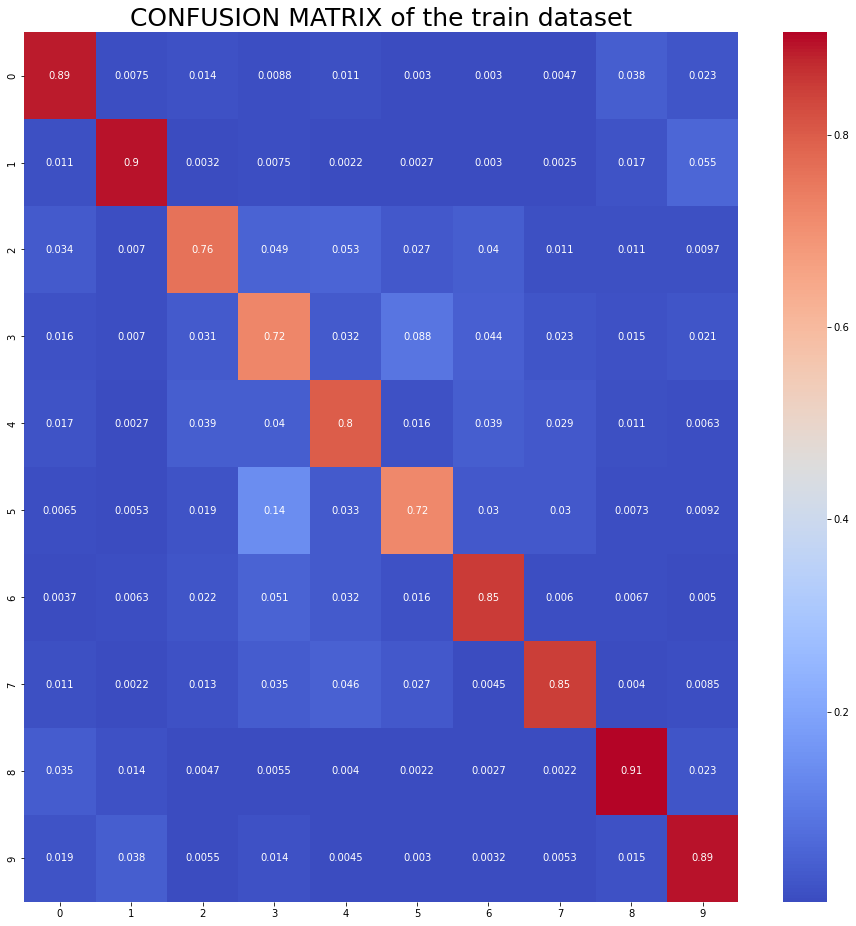

In [24]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(16, 16))
sns.heatmap(
    confusion_matrix(
        train_y_true,
        train_y_pred,
        normalize ='true'), 
        annot=True, cmap='coolwarm'
        )
plt.title("CONFUSION MATRIX of the train dataset", fontsize=25)
plt.show()

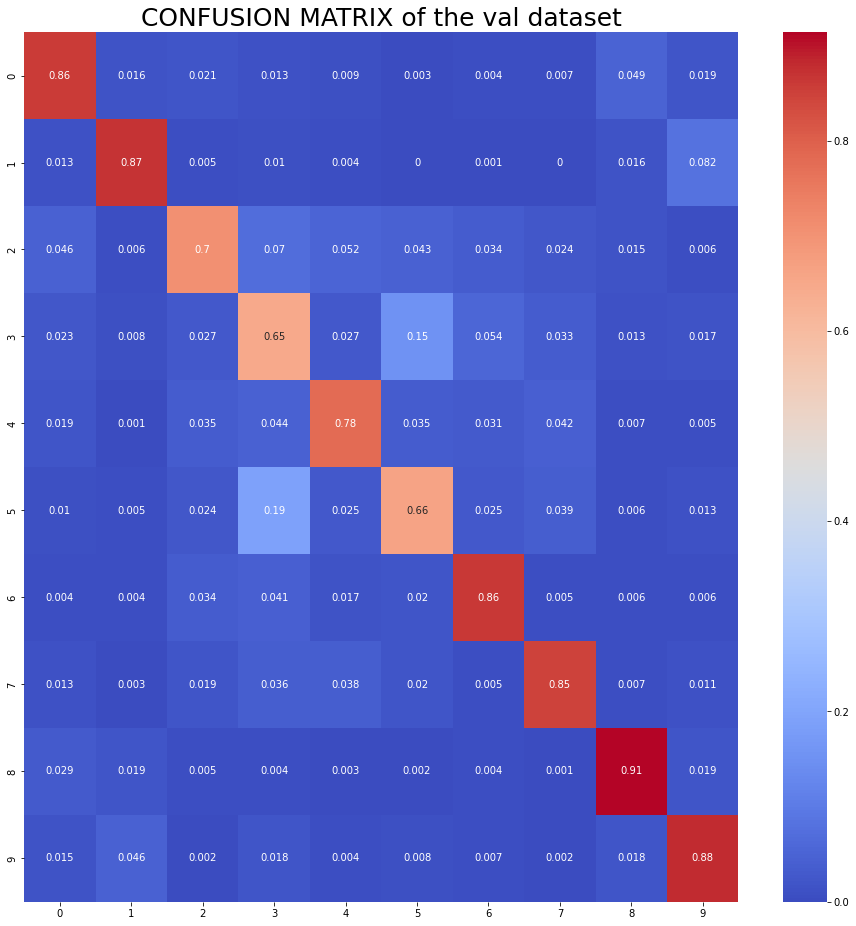

In [25]:
plt.figure(figsize=(16, 16))
sns.heatmap(
    confusion_matrix(
        val_y_true,
        val_y_pred,
        normalize = 'true'), 
        annot=True, cmap='coolwarm'
        )
plt.title("CONFUSION MATRIX of the val dataset", fontsize=25)
plt.show()

# 추론 

이제 학습이 완료되었습니다! 

그럼 test 데이터를 예측해 보아요.

test 데이터를 불어옵니다.

In [26]:
from glob import glob
import PIL.Image
import numpy as np

test_images = []

path = './data/'
for filename in sorted(glob(path + "test/*.jpg")):
    an_img = PIL.Image.open(filename) 
    img_array = np.array(an_img) 
    test_images.append(img_array) 

test_images = np.array(test_images)

In [27]:
class CustomDataset(Dataset):
    def __init__(self, transform):
        self.transform = transform 
        self.img_list = test_images
        self.img_labels = [0] * 10000 

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        return self.transform(image=self.img_list[idx]), self.img_labels[idx]

In [28]:
test_set = CustomDataset(transform=else_transform)

test_loader = DataLoader(test_set, batch_size = test_batch_size)

In [29]:
def test(model, loader, epoch, nb_epochs):

    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)

In [30]:
next(iter(test_loader))[0]['image'][0].shape

torch.Size([3, 32, 32])

본격적으로 test 데이터를 예측해보아요! 

예측을 할 때는 학습이 진행되지 않도록 net.eval() 코드를 작성해주어야 합니다. 

데이터가 backpropagation 되어 가중치가 수정되지 않도록 해주는 코드입니다. 

In [31]:
import pandas as pd
sample_submission = pd.read_csv('./data/sample_submission.csv')

model.eval()

batch_index = 0
with torch.no_grad():
    for i, (images, targets) in enumerate(test_loader):
        images = images['image'].to(device)
        outputs = model(images)
        batch_index = i * test_batch_size
        max_vals, max_indices = torch.max(outputs, 1)
        sample_submission.iloc[batch_index:batch_index + test_batch_size, 1:] = max_indices.long().cpu().numpy()[:,np.newaxis]

예측된 데이터의 라벨은 숫자로 되어있습니다. 

train 데이터를 불러올 때 ImageFolder 메소드를 사용해 데이터를 불러왔기 때문입니다. 

제출을 위해 라벨을 다시 복원 시켜 줍니다.

In [32]:
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
          5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}
sample_submission['target'] = sample_submission['target'].map(labels)

In [33]:
sample_submission.head()

,id,target
0,0000.jpg,horse
1,0001.jpg,bird
2,0002.jpg,airplane
3,0003.jpg,horse
4,0004.jpg,airplane


In [34]:
sample_submission.to_csv(f'{np.max(val_acc_list):.4f}_'+f'{save_name}.csv', index=False)

축하합니다! 데이터 분석을 완료하셨습니다!

앞으로도 데이콘과 함께 즐겁게 데이터 분석 능력을 키워가시면 좋겠습니다.

감사합니다.